In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mne
import pickle
from scipy import signal
from scipy.fft import fft, fftfreq, ifft
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from matplotlib import animation
from IPython.display import clear_output

%matplotlib widget
plt.rcParams.update({'font.size': 12})

In [ ]:
# Load data
dataset_path = os.path.join('cichy_data', 'subj0', 'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)
raw.info.update({'sfreq':250})

# kernel network FIR

In [ ]:
outputs = []
num_kernels = 5  # number of kernels per layer
layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet

# for each layer load the kernels and compute the power spectrum
for i in layer_ind:

    # this path should point to the output of kernel FIR analysis from a trained model
    # please see the examples section of the README in this repo for
    # how to run this analysis
    path = '../results/cichy_epoched/all_noshuffle_wavenetclass_semb10_drop0.4/kernels_network_FIRch0/'
    path += 'conv' + str(i) +'.mat'
    data = loadmat(open(path, 'rb'))
    data = data['X'][:, :124000]

    for j in range(num_kernels):
        f, pxx = signal.welch(data[j], fs=250, nperseg=8*250)

        pxx = pxx/np.std(pxx)
        outputs.append(pxx)
outputs = np.array(outputs)

In [ ]:
freqs = np.tile(f, (outputs.shape[0], 1))
freqs = freqs.reshape(-1)

# kernels
kernels = np.tile(np.arange(outputs.shape[0]), (outputs.shape[1], 1)).T
kernels = kernels.reshape(-1)

# layers
layers = np.tile(np.repeat(layer_ind, num_kernels), (outputs.shape[1], 1)).T
layers = layers.reshape(-1)

hue = np.tile(np.arange(num_kernels), (outputs.shape[1], len(layer_ind))).T
hue = hue.reshape(-1)

# create a pandas dataframe for plotting
pd_dict = {'Power': outputs.reshape(-1), 'Frequency (Hz)': freqs, 'kernels': kernels, 'Layer': layers, 'K': hue}
pfi_pd = pd.DataFrame(pd_dict)

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", facet_kws={'sharey': False, 'sharex': True},
    x="Frequency (Hz)", y="Power", hue='kernels', n_boot=0, legend=None, estimator=None,
    row='Layer', col='K', aspect=1.8, height=1.5
)

# Spectral

In [ ]:
# this path should point to the output of spectral PFI from a trained model
# please see the examples section of the README in this repo for
# how to run this analysis
path = '../results/cichy_epoched/all_noshuffle_wavenetclass_semb10_drop0.4/kernelPFI/val_loss_PFIfreqs4.npy'
pfi = np.load(open(path, 'rb'))
pfi = pfi[:, 2:, :]

In [ ]:
# select layers
layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet
inds = [True if int(i/5) in layer_ind else False for i in range(30) ]
pfi = pfi[:, :, inds]

In [ ]:
xf = fftfreq(256, 1/250)[:256//2]
xf = xf[3:126]
xf = np.round(xf)

times = np.array([xf for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# kernels
kernels = np.repeat(np.arange(pfi.shape[2]).reshape(1, -1), [pfi.shape[1]], axis=0)
kernels = np.repeat(kernels.reshape(1, kernels.shape[0], -1), [pfi.shape[0]], axis=0)
kernels = kernels.reshape(-1)

# layers
layers = np.repeat(np.repeat(layer_ind, 5).reshape(1, -1), [pfi.shape[1]], axis=0)
layers = np.repeat(layers.reshape(1, layers.shape[0], -1), [pfi.shape[0]], axis=0)
layers = layers.reshape(-1)

# create a pandas dataframe for plotting
pd_dict = {'Output deviation': pfi.reshape(-1), 'Frequency (Hz)': times, 'kernels': kernels, 'Layer': layers}
pfi_pd = pd.DataFrame(pd_dict)

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", facet_kws={'sharey': False, 'sharex': True},
    x="Frequency (Hz)", y="Output deviation", hue='kernels', n_boot=10, legend=None,
    row='Layer', height=2, aspect=2
)

# SpatioSpectral

In [ ]:
# this path should point to the output of spatio-spectral PFI from a trained model
# please see the examples section of the README in this repo for
# how to run this analysis
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'kernelPFI',
                    'val_loss_PFIfreqs_ch4.npy')
pfi = np.load(open(path, 'rb'))
pfi = pfi[0, :, 1:, :]
pfi = pfi.transpose(2, 0, 1)

layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet
pfi = pfi[layer_ind, :, :]

In [ ]:
# times array
xf = fftfreq(256, 1/250)[:256//2]
xf = xf[3:126]
xf = np.round(xf)
xf = np.tile(xf, (pfi.shape[0], pfi.shape[2], 1))
xf = xf.transpose(0, 2, 1).reshape(-1)

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=1))
mags_max = mags.max(axis=1)[:, np.newaxis]
mags = np.array([mags/mags_max for _ in range(pfi.shape[1])])
mags = mags.transpose(1, 0, 2).reshape(-1)

layers = np.tile(layer_ind, (pfi.shape[1], pfi.shape[2], 1))
layers = layers.transpose(2, 0, 1).reshape(-1)

pfi_pd = pfi.reshape(-1)

In [ ]:
# put everything in a pd dataframe
pd_dict = {'Output deviation': pfi_pd, 'Frequency (Hz)': xf, 'relative magnitude': mags, 'Layer':layers}
pfi_pd = pd.DataFrame(pd_dict)

In [ ]:
# any Elekta data path will work here as all we need is the 
# magnetometer channel locations to populate the mne.info object
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)
#raw.info.update({'sfreq':250})  # set the sampling frequency to 250 Hz

In [ ]:
mags = np.abs(np.mean(pfi, axis=1))
evokeds = []

# create evoked objects for plotting
for i in range(mags.shape[0]):
    evokeds.append(mne.EvokedArray(mags[i:i+1, :].T, raw.info, tmin=0))

In [ ]:
# plot the topomaps for each layer
fig, axes = plt.subplots(6)
for i in range(6):
    evokeds[i].plot_topomap(axes=axes[i],
                            times=[0],
                            ch_type='mag',
                            time_unit='ms',
                            scalings=1,
                            units='Output deviation',
                            vmin=0,
                            time_format='',
                            colorbar=False)

In [ ]:
%matplotlib widget
# plot the channel-wise spectral PFI
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", n_boot=10, height=2, facet_kws={'sharey': False, 'sharex': True},
    x="Frequency (Hz)", y="Output deviation", hue='relative magnitude', legend=None, palette='Reds', aspect=2, row='Layer'
)

# Temporal

In [ ]:
# this path should point to the output of temporal PFI from a trained model
# please see the examples section of the README in this repo for
# how to run this analysis
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'kernelPFI',
                    'val_loss_PFIts.npy')
pfi = np.load(open(path, 'rb'))
#pfi = np.mean(pfi, axis=0)
pfi = pfi[:, 2:, :]

# normalization for better visualization
pfi = (pfi - np.mean(pfi, axis=1, keepdims=True))/np.std(pfi, axis=1, keepdims=True)

In [ ]:
layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet
inds = [True if int(i/5) in layer_ind else False for i in range(30) ]
pfi = pfi[:, :, inds]

In [ ]:
times = np.array([np.arange(-48, 868, 4) for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# kernels
kernels = np.repeat(np.arange(pfi.shape[2]).reshape(1, -1), [pfi.shape[1]], axis=0)
kernels = np.repeat(kernels.reshape(1, kernels.shape[0], -1), [pfi.shape[0]], axis=0)
kernels = kernels.reshape(-1)

# layers
layers = np.repeat(np.repeat(layer_ind, 5).reshape(1, -1), [pfi.shape[1]], axis=0)
layers = np.repeat(layers.reshape(1, layers.shape[0], -1), [pfi.shape[0]], axis=0)
layers = layers.reshape(-1)

pd_dict = {'Output deviation': pfi.reshape(-1), 'Time (ms)': times, 'kernels': kernels, 'Layer': layers}
pfi_pd = pd.DataFrame(pd_dict)

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", facet_kws={'sharey': False, 'sharex': True},
    x="Time (ms)", y="Output deviation", hue='kernels', n_boot=10, legend=None,
    row='Layer', aspect=2.2, height=2
)

# SpatioTemporal

In [7]:
# this path should point to the output of spatio-temporal PFI from a trained model
# please see the examples section of the README in this repo for
# how to run this analysis
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'kernelPFI',
                    'val_loss_PFIch4.npy')
pfi = np.load(open(path, 'rb'))

layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet
pfi = pfi[:, :, 1:, layer_ind]

In [8]:
# times array
times = np.tile(np.arange(-48, 872, 4), (pfi.shape[0], pfi.shape[2], pfi.shape[3], 1))
times = times.transpose(0, 3, 1, 2).reshape(-1)

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=1))
mags_max = mags.max(axis=1, keepdims=True)
mags = np.array([mags/mags_max for _ in range(pfi.shape[1])])
mags = mags.transpose(1, 0, 2, 3).reshape(-1)

layers = np.tile(layer_ind, (pfi.shape[0], pfi.shape[1], pfi.shape[2], 1))
layers = layers.reshape(-1)

pfi_pd = pfi.reshape(-1)

In [9]:
# put everything in a pd dataframe
pd_dict = {'Output deviation': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'Kernel = 4 | Layer': layers}
pfi_pd = pd.DataFrame(pd_dict)

In [10]:
mags = np.abs(np.mean(pfi, axis=(0,1)))
evokeds = []
for i in range(mags.shape[1]):
    # create evoked objects for plotting
    # see channel-wise spectral PFI for how to get the raw object
    evokeds.append(mne.EvokedArray(mags[:, i:i+1], raw.info, tmin=0))

In [ ]:
fig, axes = plt.subplots(6)
for i in range(6):
    evokeds[i].plot_topomap(axes=axes[i], times=[0], ch_type='mag', time_unit='ms', scalings=1, units='Output deviation', vmin=0, time_format='', colorbar=False)

#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/kernel_spatiotemporal_head.pdf', format='pdf', transparent=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/kernel_spatiotemporal_chn_30.pdf'

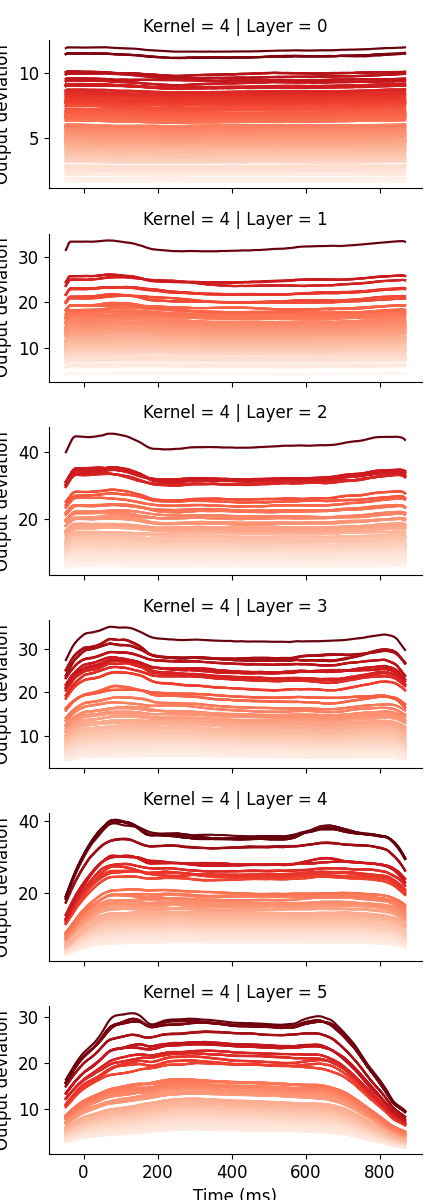

In [11]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", n_boot=10, facet_kws={'sharey': False, 'sharex': True},
    x='Time (ms)', y="Output deviation", hue='relative magnitude', legend=None, palette='Reds', aspect=2.2, row='Kernel = 4 | Layer', height=2
)

plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/kernel_spatiotemporal_chn_30.pdf', format='pdf')

# Spatial

In [ ]:
# this path should point to the output of spatial PFI from a trained model
# please see the examples section of the README in this repo for
# how to run this analysis
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'kernelPFI',
                    'val_loss_PFIch1.npy')
pfi = np.load(open(path, 'rb'))
pfi = np.mean(pfi[:, 0, 1:, :], axis=0, keepdims=True)

In [ ]:
layer_ind = [0, 1, 2, 3, 4, 5]  # layer indices in wavenet
inds = [True if int(i/5) in layer_ind else False for i in range(30) ]
pfi = pfi[:, :, inds]

In [ ]:
inds = [i for i in range(pfi.shape[2]) if i%5 > -1]
pfi = pfi[:, :, inds]

In [ ]:
evokeds = []
# create evoked objects for plotting
# see channel-wise spectral PFI section in this notebook for how to get the raw object
for i in range(pfi.shape[2]):
    evokeds.append(mne.EvokedArray(pfi[:, :, i].T, raw.info, tmin=0))

In [ ]:
# plot the spatial PFI of 5 kernels in each layer
nk = 5
nl = 6
fig, axes = plt.subplots(nl, nk)
for i in range(pfi.shape[2]):
    ax = axes[int(i/nk)][i%nk]
    evokeds[i].plot_topomap(axes=ax, times=[0], ch_type='mag', time_unit='ms', scalings=1, units='Output deviation', vmin=0, time_format='', colorbar=False)
    if i%nk == 0:
        ax.set_ylabel('Layer ' + str(layer_ind[int(i/nk)]))
        
    if i<nk:
        ax.set_xlabel('Kernel ' + str(i))
        ax.xaxis.set_label_position('top') 
        

#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/kernel_spatial_PFI.pdf', format='pdf')

# Spatio-Temporal

In [ ]:
path = os.path.join('..', 'results', 'cichy_epoched', 'wavenetclasslinear', 'kernel_PFI',
                    'val_loss_PFIch4.npy')
pfi = np.load(open(path, 'rb'))
pfi = np.mean(pfi, axis=0)
pfi = pfi[:, 1:]

In [ ]:
times = list(range(-50, 866, 4))
ticks = list(range(len(times)))

In [ ]:
evokeds = []
for i in range(pfi.shape[2]):
    evokeds.append(mne.EvokedArray(pfi[:, :, i].T, raw.info, tmin=-0.048))

In [ ]:
times = np.arange(-0.048, 0.866, 0.004)
fig, anim = evokeds[11].animate_topomap(
    times=times, ch_type='mag', frame_rate=20, time_unit='ms', blit=False, show=True)

In [ ]:
times = [-0.04, 0.13, 0.24, 0.5, 0.63, 0.8]
for i in range(pfi.shape[2]):
    evokeds[i].plot_topomap(times=times, ch_type='mag', time_unit='ms', scalings=1, units='Accuracy loss')

In [ ]:
if len(pfi.shape) == 3:
    pfi_all = pfi.reshape(1, pfi.shape[0], pfi.shape[1], -1)

pfi_pds = []
for i in range(pfi_all.shape[3]):
    pfi = pfi_all[:, :, :, i]
    # times array
    times = np.array([np.arange(-48, 872, 4) for _ in range(pfi.shape[0])])
    times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
    times = times.reshape(-1)

    # channels array
    pfi_pd = pfi.reshape(-1, pfi.shape[2])

    # magnitudes for color hues
    mags = np.abs(np.mean(pfi, axis=(0, 1)))
    mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
    mags = mags.reshape(-1)

    pfi_pd = pfi_pd.reshape(-1)

    # put everything in a pd dataframe
    pd_dict = {'Output deviation': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
    pfi_pds.append(pd.DataFrame(pd_dict))

In [ ]:
%matplotlib widget
for i in range(pfi_all.shape[3]):
    pfi_plot = sns.relplot(
        data=pfi_pds[i], kind="line", style='channels',
        x="Time (ms)", y="Output deviation", hue="relative magnitude", n_boot=10, legend='brief', palette='Reds', aspect=1.5
    )